### WAP to retrain a pretrained imagenet model to classify a medical image dataset.

#### Description of the model

* A convolutional neural network (CNN) model using transfer learning with VGG16 to classify CT images into two categories: COVID and Non-COVID of a Covid-19 Lung CT-scan dataset.
*  The VGG16 model is used as the base model, excluding the fully connected layers. This model has been pre-trained on the ImageNet dataset.
* Added custom classification head with Flatten → Dense(256, ReLU) → Dropout(0.5) → Dense(1, Sigmoid).
* Trained using binary cross-entropy loss and Adam optimizer.
* Image size taken is 224.
* Epoch used is 10 and batch size is 32.
* Evaluated using accuracy, F1 score, and AUC.
* Plotted training curves, ROC curve, and confusion matrix.
* Saved all results and trained model to Google Drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 596 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.5782 - loss: 0.7358
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.7888 - loss: 0.4650
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.8490 - loss: 0.3293
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8708 - loss: 0.2840
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9246 - loss: 0.2220
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9097 - loss: 0.2216
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9602 - loss: 0.1455
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9608 - loss: 0.1342
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9785 - loss: 0.1102
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9807 - loss: 0.0947
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step



Classification Report:

              precision    recall  f1-score   support

    CT_COVID       0.95      0.77      0.85        70
 CT_NonCOVID       0.83      0.96      0.89        80

    accuracy                           0.87       150
   macro avg       0.89      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150

F1 Score: 0.8902
Accuracy: 0.8733
AUC: 0.9452


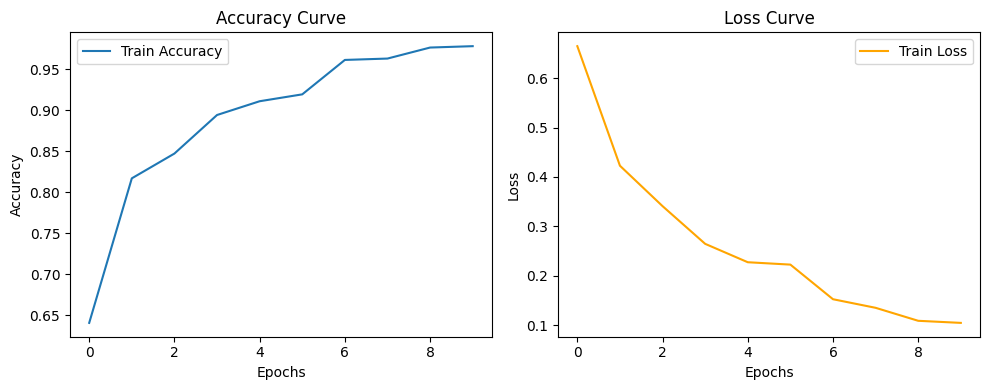

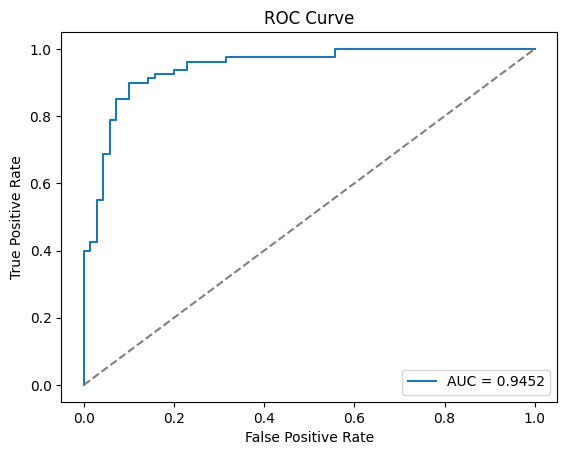

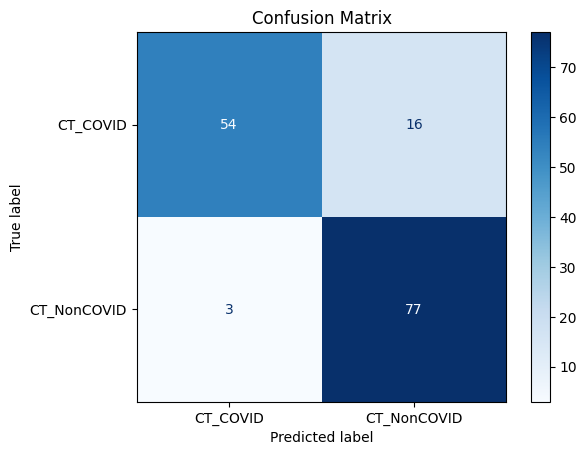

Confusion matrix saved to: /content/drive/MyDrive/nnexp7_files/confusion_matrix.png

 All results saved to: /content/drive/MyDrive/nnexp7_files


In [12]:
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 3. Dataset Setup
data_dir = '/content/drive/MyDrive/Covid_CT'
categories = ['CT_COVID', 'CT_NonCOVID']

filepaths, labels = [], []

for category in categories:
    folder = os.path.join(data_dir, category)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(folder, fname))
            labels.append(category)

df = pd.DataFrame({'filename': filepaths, 'label': labels})


# 4. Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 5. Data Generators
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label',
    target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label',
    target_size=(img_size, img_size), batch_size=1,
    class_mode='binary', shuffle=False
)

# 6. Build Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 7. Train Model
history = model.fit(train_gen, epochs=10)

# 8. Evaluate Model
pred_probs = model.predict(test_gen)
preds = (pred_probs > 0.5).astype(int).reshape(-1)
true = test_gen.classes

f1 = f1_score(true, preds)
acc = accuracy_score(true, preds)
auc = roc_auc_score(true, pred_probs)
report = classification_report(true, preds, target_names=test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(report)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")

# 9. Save Results to Google Drive
results_path = '/content/drive/MyDrive/nnexp7_files'
os.makedirs(results_path, exist_ok=True)

# (a) Save metrics
with open(f'{results_path}/metrics_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report + '\n')
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"AUC: {auc:.4f}\n")

# (b) Save model
model.save(f'{results_path}/vgg16_covid_classifier.h5')

# (c) Plot accuracy/loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f'{results_path}/training_curves.png')
plt.show()

# (d) Plot AUC curve
fpr, tpr, _ = roc_curve(true, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig(f'{results_path}/auc_curve.png')

# 10. Confusion Matrix
cm = confusion_matrix(true, preds)

# Display confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues')

# Save confusion matrix plot
plt.title('Confusion Matrix')
plt.savefig(f'{results_path}/confusion_matrix.png')
plt.show()

print(f"Confusion matrix saved to: {results_path}/confusion_matrix.png")

print(f"\n All results saved to: {results_path}")

#### Description of the code

##### 1. Mounting Google drive
* This step mounts Google Drive to the Colab environment, allowing access to files stored on the user's Google Drive.
* This is particularly useful for accessing the dataset and saving the trained model and results.

##### 2. Import Libraries
* Pandas is used for handling and manipulating data (creating DataFrames).
* NumPy is used for numerical operations, though not directly visible in the code here.
* Matplotlib is used for plotting graphs and visualizing training curves, ROC curves, and confusion matrix.
* Scikit-learn is used for splitting the dataset and calculating various evaluation metrics like F1 score, accuracy, and AUC.
* Keras/TensorFlow is used for building the neural network model, data preprocessing (with ImageDataGenerator), and loading the pre-trained VGG16 model.

##### 3. Dataset setup
* The path to the dataset on Google Drive is specified.
* The dataset is organized into two categories: CT_COVID and CT_NonCOVID, which are the labels for the two classes.
* The code loops through each category folder (CT_COVID and CT_NonCOVID), and retrieves the file paths of images (.png, .jpg, .jpeg).
* These file paths and their corresponding labels are stored in two lists: filepaths and labels.

##### 4. Train-test split
* The dataset is split into training (80%) and testing (20%) sets using train_test_split.
* The stratify argument ensures the class distribution (COVID and Non-COVID) is preserved in both training and test sets.

##### 5. Data Generators
* ImageDataGenerator is initialized to rescale pixel values to a range of [0, 1] (from the original range of [0, 255]).
* Image size is set to 224x224 pixels, which is the required input size for the VGG16 model.
* The test data generator (test_gen) loads images similarly but with a batch size of 1 for evaluation and no shuffling (important for consistency in results).

##### 6. Model Building
* VGG16 is loaded without the top (fully connected) layers, using pre-trained weights from ImageNet.
* The include_top=False ensures the model only contains convolutional layers, which will be used for feature extraction.
* The trainable=False line freezes the weights of the base model, preventing them from being updated during training.
* A Flatten layer is applied to convert the 3D feature maps into a 1D vector.
* A Dense layer with 256 units and ReLU activation is added for non-linearity.
* A Dropout layer with a rate of 0.5 is added to reduce overfitting by randomly setting half of the neurons to zero during each training step.
* The final output layer is a sigmoid activation for binary classification (COVID or Non-COVID).
* The model is compiled with:
    - Adam optimizer with a learning rate of 1e-4 for efficient training.
    - Binary cross-entropy loss because it’s a binary classification problem.
    - Accuracy as the evaluation metric.

##### 7. Model Train
* The model is trained for 10 epochs using the training data generator (train_gen).
* The training process includes tracking the accuracy and loss over the epochs.

##### 8. Model Evaluation
* Predictions are made on the test set.
* Probabilities are converted into binary predictions (0 or 1) using a threshold of 0.5.
* The true labels are obtained from the test generator.
* F1 score, accuracy, and AUC (Area Under the Curve) are calculated to evaluate the model’s performance.
* A classification report is generated, which includes precision, recall, F1 score, and support for each class.
* The confusion matrix plot are also visualized.



#### My Comments
* The accuracy of the model is 87.33% and the F1_score is 89.02%.
* As by confusion matrix, the misclassification is fewer as it has correctly classified Covid and NonCovid categories of CT scan.
* There may be limitation in performance of the model as dataset quantity is less.
* Instead of VGG16 we can use ResNet like model for better generalisation and performance.